# Working with priors

In this session, we are still working with the eczema medical trial case study but we are not using the data set. This session is all about priors and something called the prior-predictive distribution.

The purpose of this part of the Bayesian data analysis workflow is to check that our model behaves the way we think it should — based on our assumptions. It is possible that we designed the model incorrectly or that our prior parameters don't really match what we believe before seeing the data.

If the model doesn't behave the way we think it should, we can iterate on the model by changing the distributions or parameter values of the prior or likelihood to get a better model — one that is a better fit to our prior knowledge.

## Prep plan

* The McElreath reading should take ~1 hour.
* Watching the Youtube videos should take ~15 minutes.
* This workbook should take ~45 minutes. (The optional parts will take longer.)

## Review

In CS114, we covered _conjugate priors_, a special type of prior distribution in Bayesian inference.

* **Definition:** A prior is *conjugate* to a likelihood if the resulting posterior is the same type of distribution as the prior.

* **Examples:**

  * **Gamma–Poisson:** A Gamma prior on the Poisson rate parameter produces a Gamma posterior.
  * **Beta–Binomial:** A Beta prior with Binomial likelihood yields a Beta posterior.
  * There are many more examples and you can find [a list of them in Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

* **Use in Bayesian inference:** Conjugate priors make Bayesian inference mathematically convenient, since posteriors and marginal likelihoods can be computed _in closed form_.¹ Because we can compute the posterior in closed form, we don't need to run the (much slower) PyMC sampler to approximate the posterior distribution. We have the exact answer.

  > 1. _In closed form_ means you can do the math and get the formula for the posterior and the marginal likelihood. If a prior is not conjugate, this is usually impossble. (Why is it impossible? Because the integral in the marginal likelihood doesn't have a mathematical solution.)

* **Warnings**: Conjugate priors are not always appropriate. We should avoid them if:

  * the support of the prior doesn’t match the true belief (for example, finite vs. infinite support),
  * the shape of the distribution doesn’t capture prior beliefs (for example, multimodal beliefs but unimodal Gamma),
  * the prior information cannot be meaningfully encoded by the conjugate distribution,
  * or there are other conceptual mismatches.

## Required reading: Statistical rethinking

Read Sections 2.1–2.3 of McElreath, R. (2020). _Statistical Rethinking, Second Edition_. Chapman and Hall/CRC Press.

* [Publisher's page](https://www.routledge.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) for buying the book if you want to
* [Chapter 2 is available as a free sample chapter here](https://xcelab.net/rm/statistical-rethinking/)
* [The whole book is available online on O'Reilly via the San Francisco Public Library](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/10_Chapter02.xhtml). Log in with your library card number.

**Most of today's pre-class work is reading the textbook.** There is an example and some questions for you to answer below but expect to spend most of your time reading.

Outline

* **The introduction section is required** (870 words).
* Section 2.1 (_The garden of forking data_) is optional (4240 words) for those who want to review their basic probability concepts. It reviews the counting foundations of probability theory and the basic concepts of Bayesian inference.
* **Section 2.2 (_Building a model_) is required** (2300 words). The two key ideas here are (1) that we can (and should) think of a statistical model as a generative process — as a story that tells us how all the variables in the universe of our model get generated — and (2) why we should think of inference as inverse probability — as reversing the direction of the flow of information in a model.
* **Section 2.3 (_Components of the model_) is required** (2350 words). This section goes through the process of constructing a model in detail and provides important historical and philosophical background on Bayesian statistics. Everything in this section is important for your development as a statistician. The focus for today is on the use of the prior and the likelihood to define the data distribution of a model.

## Prior-predictive distribution

### Summary

Some terminology:

* The _prior distribution_ is the distribution over unknown variables (parameters) of the model without incorporating any data.
* The _prior-predictive distribution_ is, intuitively, the distribution over the possible data sets (observed variables) that our model can generate. In this distribution, we are **not** conditioning on the real data (that would give us the posterior distribution) but instead generating samples from the likelihood function as if it is a distribution over the possible data sets.

In short, the prior-predictive distribution generates/simulates possible data sets from the model. And, just to emphasize this again, we do this without looking at (conditioning on) the real data set.

### Required videos

* Watch Lambert, B. (2014, August 12). [Prior and posterior predictive distributions, an introduction](https://www.youtube.com/watch?v=R9NQY2Hyl14). Youtube. (6 minutes)

  This video actually covers two concepts, the prior-predictive distribution and the posterior-predictive distribution. Focus on the prior-predictive distribution for today but watch the whole video. We discuss the posterior-predictive distribution and its uses in the next lesson. The video contains lots of integrals which are very helpful for understanding what is happening conceptually. However, we compute almost no integrals in this course since the focus is on computational approximations to distributions, which are usually used in practice.

* Watch Lambert, B. (2014, August 12). [Prior predictive distribution example, disease](https://www.youtube.com/watch?v=DR_sr23C74A). Youtube. (8 minutes)

  This example demonstrates how the prior and prior-predictive distributions change together using an example similar to our medical trial case study. The mathematical derivation starting from 5:30 is optional.

## Case study: Medical trials

Let's look at an example.

We use the same model as in the previous lessons.

Likelihood:

$$x\sim\text{Binomial}(n,p)$$

Prior:

$$p\sim\text{Beta}(1,1)$$

These two parts, the prior and the likelihood, constitute the full prior-predictive distribution. It is a joint distribution over $p$ and $x$ (we assume $n$ is known or at least constant) with the PDF

$$f(p,x) = f_{\text{Binomial}}(x\,|\,n,p)\,f_{\text{Beta}}(p\,|\,\alpha=1,\beta=1)$$

We won't work with this PDF directly but it is important that you understand that, in general, the prior-predictive distribution is a joint distribution over all parameter (unobserved) random variables and data (observed) random variables of the model.

To generate samples from this model, we first generate a sample from the prior $p\sim\text{Beta}(1,1)$, and then, given the value we just generated for $p$, we generate a sample from the likelihood, $x\sim\text{Binomial}(n,p)$.

**Run the code cells below** to generate samples from this model using PyMC.

In [1]:
import pymc as pm
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt


with pm.Model() as model:
    p = pm.Beta('p', alpha=1, beta=1)

    '''
    The value of `n` below is made up. We're looking at how the model behaves
    when we have 100 patients. The value of `observed` below is also made up and
    we won't use it at all. For technical reasons, PyMC treats observed
    variables differently from unobserved ones. If we left out the `observed=30`
    below, PyMC would treat this Binomial as part of the prior distribution and
    not as the likelihood function.
    '''

    pm.Binomial('x', n=100, p=p, observed=30)

# Sample from the prior and prior-predictive distributions
n_samples = 2000
with model:
    inference = pm.sample_prior_predictive(n_samples)

inference

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

The inference object now has two parts, namely prior and prior_predictive. The prior part contains all unobserved variables ($p$) and the prior_predictive part contains all observed variables ($x$). Click on the ▶ above to view the prior and prior-predictive data.

Below we plot

* the marginal distribution over $p$ which is the prior over $p$,
* the marginal distribution over $x$ which is the prior-predictive distribution over $x$,
* the joint distribution over ($p,x$) which is the full joint distribution over all variables (observed and unobserved) in our model.

The final plot is helpful for understanding how $p$ and $x$ depend on each other.

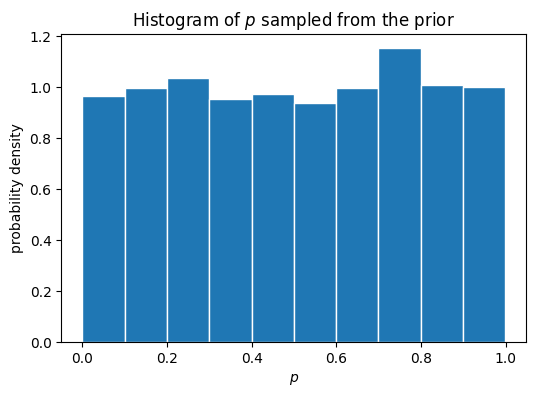

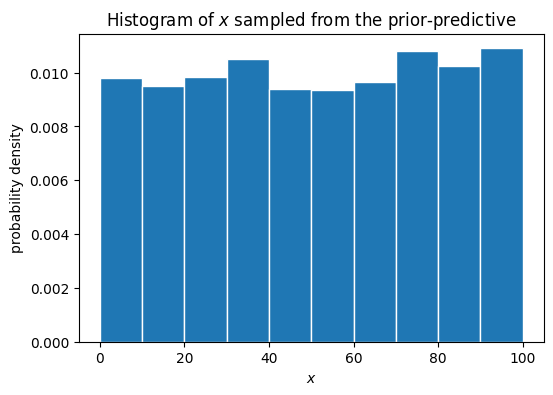

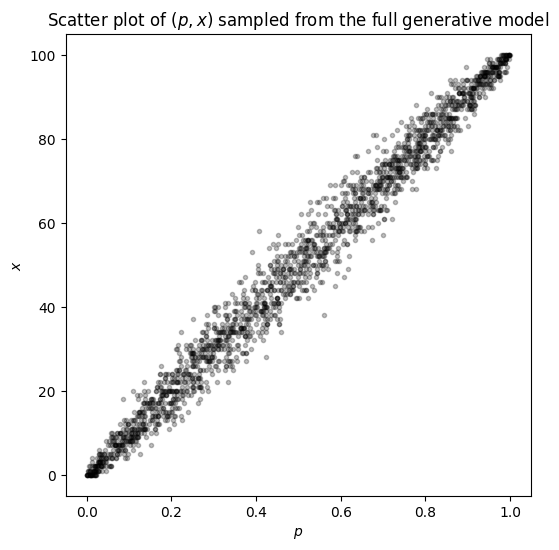

In [2]:
plt.figure(figsize=(6, 4))
plt.title('Histogram of $p$ sampled from the prior')
plt.xlabel('$p$')
plt.ylabel('probability density')
plt.hist(
    inference.prior.p.values.flatten(), bins=10, density=True,
    edgecolor='white')

plt.figure(figsize=(6, 4))
plt.title('Histogram of $x$ sampled from the prior-predictive')
plt.xlabel('$x$')
plt.ylabel('probability density')
plt.hist(
    inference.prior_predictive.x.values.flatten(), bins=10, density=True,
    edgecolor='white')

plt.figure(figsize=(6, 6))
plt.title('Scatter plot of $(p,x)$ sampled from the full generative model')
plt.xlabel('$p$')
plt.ylabel('$x$')
plt.plot(
    inference.prior.p.values.flatten(),
    inference.prior_predictive.x.values.flatten(),
    'k.', alpha=0.25)

plt.show()

### Questions

Why is $p$ uniformly distributed?

In [ ]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM

Why is $x$ uniformly distributed? (This is much less obvious than the previous question so think carefully.)

In [ ]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM

Why are $p$ and $x$ strongly correlated in the scatter plot (the third plot) above?

In [ ]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM

Why are $p$ and $x$ not perfectly correlated? Why is there still some variation in $x$ for a given value of $p$?

In [ ]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM

Why is there less variation in $x$ for values of $p$ close to 0 and 1 and more variation in $x$ for values of $p$ close to 0.5?

In [ ]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM

## (Optional) Case study: Linear regression

Below is a fairly standard model for linear regression.

Likelihood:

$$y_i\sim\text{Normal}(\alpha x_i + \beta,\sigma^2)$$

Prior:

$$\alpha\sim\text{Normal}(0, 10^2)$$
$$\beta\sim\text{Normal}(0, 10^2)$$
$$\sigma\sim\text{Half-Normal}(1^2)$$

Generate the prior-predictive distribution over $\{y_i\}$ for this model, assuming the values of $\{x_i\}$ are given. Plot some samples from the prior-predictive distribution and consider whether they make sense or not.

Record your observations here. Is there anything about the prior-predictive distribution that doesn't match what you would expect from linear regression? These observations can help us improved our model.

In [ ]:
# YOUR WORK GOES HERE